In [22]:
#from IPython.display import Image
#Image(filename='MultiAgent.png',width=800)

### Initializing the keys

In [39]:
import os
from dotenv import load_dotenv

load_dotenv()


from langchain_openai import ChatOpenAI

# Now you can access your environment variables using os.environ
os.environ['OPENAI_API_KEY'] = os.environ.get("OPENAI_API_KEY")
os.environ['TAVILY_API_KEY'] = os.environ.get("TAVILY_API_KEY")


llm = ChatOpenAI(model="gpt-4-1106-preview")

### Create Agent function

In [40]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4-1106-preview")

def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor



### Creation of Tools 

- Tavily Search tool
- PythonREPLTool

In [41]:
from typing import Annotated, List, Tuple, Union

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.tools import PythonREPLTool

tavily_tool = TavilySearchResults(max_results=5)

python_repl_tool = PythonREPLTool()

### RAG Setup with vector DB

In [42]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma

### Reading the txt files from source directory

loader = DirectoryLoader('./source', glob="./*.py", loader_cls=TextLoader)
docs = loader.load()

### Creating Chunks using RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=10,
    length_function=len
)
new_docs = text_splitter.split_documents(documents=docs)
doc_strings = [doc.page_content for doc in new_docs]

###  BGE Embddings

from langchain.embeddings import HuggingFaceBgeEmbeddings

model_name = "BAAI/bge-base-en-v1.5"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': True} # set True to compute cosine similarity
embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs,
)

### Creating Retriever using Vector DB

db = Chroma.from_documents(new_docs, embeddings)
retriever = db.as_retriever(search_kwargs={"k": 4})

c:\Users\LTahwineyi\Desktop\final_project\LLM_RAG_Model_Deployment\.conda\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [43]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

### RAG Tool : Python function -> tool

In [44]:
#from utils import llm
@tool
def RAG(state):

    """Use this to execute RAG. If the question is related to Python code error, using this tool retrieve the results."""

    print('-> Calling RAG ->')
    question = state
    print('Question:',question)

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    return result

### Agent node 
 - takes state , agent and name as input 
 - return mesage as HumanMessage with name

In [45]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

### Supervisor Chain creation 

Our team supervisor is an LLM node. It just picks the next agent to process and decides when the work is completed

- Has access and information about it's memebers. 
- members = ["RAG" , "Researcher", "Coder"]
- options = ["FINISH"] + members
- "Given the conversation above, who should act next?"
   " Or should we FINISH? Select one of: {options}"

- Router -> function_def

In [46]:
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
#from utils import llm

members = ["RAG" , "Researcher", "Coder"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Use RAG tool to retrive code related to the user request"
    "related to Python code error. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

options = ["FINISH"] + members
# Using openai function calling can make output parsing easier for us
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

### Creation of workflow with below nodes 

Agent ->> Node (functools.partial)

 - Research Node
 - Code Node
 - RAG Node

In [51]:
import operator
from typing import Annotated, Sequence, TypedDict
import functools
import openai
import pytest
import os
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END
from langchain.chat_models import ChatOpenAI
from langchain.schema import BaseMessage, HumanMessage
import gitpy

workflow = StateGraph(AgentState)
llm = ChatOpenAI(model="gpt-4-1106-preview")
file_path =".\source\models.py"# Adjust the file path as needed
error_log_path=".\source\models.py"

#The agent state is the input to each node in the graph
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next: str
    file_path: str
    error_log_path: str


research_agent = create_agent(llm, [tavily_tool], "You are a web researcher.")
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")


code_agent = create_agent(
    llm,
    fix_error(file_path, error_log_path),
    [python_repl_tool],
    "You may generate safe python code to fix the error in the python code."
)
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")


RAG_agent = create_agent(
    llm,
    [RAG],
    "Use this tool when questions are related to python model or python views."
)
rag_node = functools.partial(agent_node, agent=RAG_agent, name="RAG")


# Define the function to fix errors using the code agent
def fix_error(file_path, error_log_path):
    # Get the original code from the .py file
    with open(file_path, 'r') as file:
        original_code = file.read()

    # Get the error message from the error log
    with open(error_log_path, 'r') as file:
        error_message = file.read()

    # Construct the prompt for the LLM
    prompt = f"Correct the error in the following code: {original_code}\nError message: {error_message}"

    # Call the LLM to generate the corrected code
    response = openai.Completion.create(
        engine="code-davinci-002",
        prompt=prompt,
        temperature=0.5,
        max_tokens=100
    )

    # Extract the corrected code from the response
    corrected_code = response.choices[0].text.strip()

    # Save the corrected code to the file
    with open(file_path, 'w') as file:
        file.write(corrected_code)

    # Test the corrected code using pytest
    test_result = pytest.main([file_path])

    # If the test passes, commit the changes to the local repository
    if test_result == 0:
        repo = git.Repo(os.path.dirname(file_path))
        repo.git.add(file_path)
        repo.git.commit(m="Fixed error in " + file_path)

    return test_result


# Add handling for the issue of 'dict' object not having 'replace' attribute
def handle_dict_error(state):
    if isinstance(state, dict):
        state = AgentState(messages=state['messages'], next=state['next'], file_path=state['file_path'], error_log_path=state['error_log_path'])
    return state



workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("RAG", rag_node)
workflow.add_node("supervisor", supervisor_chain)
# Finally, add entry point
workflow.set_entry_point("supervisor")

# Compile the workflow graph
graph = workflow.compile()

# Function to stream the graph
def stream_graph(graph, input_state):
    try:
        for s in graph.stream(input_state):
            if "__end__" not in s:
                print(s)
                print("----")
    except KeyError as e:
        print(f"KeyError encountered: {e}")
        raise
    except TypeError as e:
        print(f"TypeError encountered: {e}")
        raise

# Input state for testing
input_state = {
    "messages": [
        HumanMessage(content="there is an error in my model class use RAG to fetch the data and correct the error, run the code want to see results in the terminal")
    ],
    "file_path": ".\source\models.py",  # Adjust the file path as needed
    "error_log_path": ".\source\models.py" 
    
}

# Stream the graph with the input state
stream_graph(graph, input_state)


APIRemovedInV1: 

You tried to access openai.Completion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742


In [35]:
members

['RAG', 'Researcher', 'Coder']

### Creation of edges

In [38]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.set_entry_point("supervisor")

graph = workflow.compile()

ValueError: Found edge starting at unknown node 'RAG'

In [13]:
##for s in graph.stream({ "messages": [    HumanMessage(content="there is an error in my model class use RAG to fetch the data and correct the error, run the code want to see results in the terminal")
#        ]
#    }
#):
#    if "__end__" not in s:
#        print(s)
#        print("----")

for s in graph.stream(
    
    "messages": [
        HumanMessage(content="there is an error in my model class use RAG to fetch the data and correct the error, run the code want to see results in the terminal")
    ],
    "file_path": "docs",
    "error_log_path": "/path/to/your/error.log"
)
    if "__end__" not in s:
        print(s)
        print("----")

SyntaxError: invalid syntax (4000591199.py, line 11)

In [14]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="What James McIlroy is aiming in sports?")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

NameError: name 'graph' is not defined

In [15]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Fetch the India's GDP over the past 5 years,"
                " then draw a line graph of it."
                " Once you code it up, finish.")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

NameError: name 'graph' is not defined

Supervisor --> RAG -> Data ->> Python --> Run --> Visualization

{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content="I have found the GDP data for Japan over the past 4 years from reliable sources. Here is the GDP of Japan for the years 2018 to 2021:\n\n- 2021: $5,034.62 billion\n- 2020: $5,055.59 billion\n- 2019: $5,117.99 billion\n- 2018: $5,488.45 billion\n\nPlease note that the figure for 2018 varies slightly in different sources. One source mentions it as $5,543.98 billion, while another states $5,488.45 billion. For consistency, I will use the latter figure for the graph.\n\nNow I will proceed to code and draw a line graph of Japan's GDP over these years. Once I've completed the code, I'll finish as instructed.\nI have gathered the necessary information to create the line graph. However, as an AI language model, I am unable to execute code or create visual graphics directly. You can take the provided data and create a line graph using software that supports graphing functions, such as Microsoft Excel,

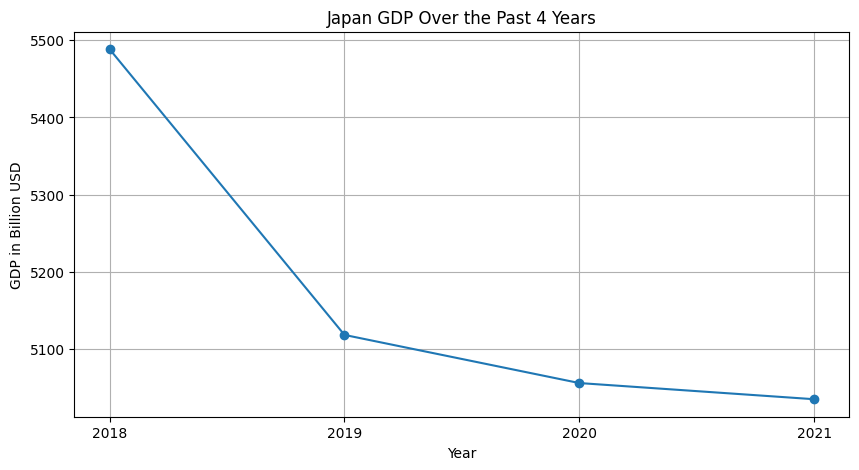

{'Coder': {'messages': [HumanMessage(content="The line graph for Japan's GDP over the past 4 years has been coded. I will now finish as instructed.", name='Coder')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [ ]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Fetch the Japans's GDP over the past 4 years from RAG,"
                " then draw a line graph of it."
                " Once you code it up, finish.")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")